In [1]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from pylab import imread,subplot,imshow,show
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras import models, layers, callbacks
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [2]:
class myCallback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print("\nAccuracy is greater than 96% so terminating training!")
            self.model.stop_training = True
            
callbacks = myCallback()

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("dataset/train",shuffle=True,image_size=(256,256),batch_size=32)

Found 4704 files belonging to 4 classes.


In [4]:
testing = tf.keras.preprocessing.image_dataset_from_directory("dataset/test",shuffle=True,image_size=(256,256),batch_size=32)

Found 1228 files belonging to 4 classes.


In [5]:
disease = dataset.class_names
disease

['Bacterialblight', 'Blast', 'Brownspot', 'Tungro']

In [11]:
(testing(0))

TypeError: 'BatchDataset' object is not callable

In [6]:
for img,lab in dataset.take(1):
    print(img.shape)
    print(lab.numpy())

(32, 256, 256, 3)
[3 3 0 1 0 3 3 2 3 1 0 3 1 2 1 1 2 0 0 3 1 1 1 0 2 2 0 0 2 3 2 1]


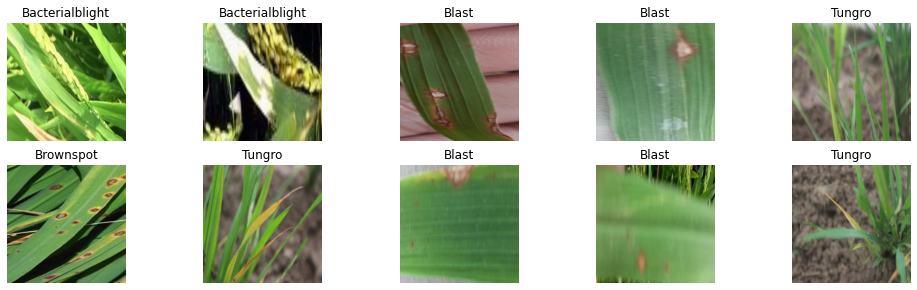

In [7]:
plt.figure(figsize=(17,10))
for img,lab in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(4,5,i+1),
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(disease[lab[i]])
        plt.axis('off')

In [8]:
len(testing)//2

19

In [9]:
valid = testing.take(8)

In [10]:
test = testing.skip(8)

In [11]:
len(valid), len(test), len(dataset)

(8, 31, 147)

In [12]:
dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [13]:
scale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(256,256),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
model = models.Sequential([
    scale,
    data_augmentation,
    # Add CNNs and maxpooling layers (trail & error work)
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.build(input_shape=(32,256,256,3))

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    dataset,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=valid,
    callbacks=[callbacks]
)

Epoch 1/50
147/147 [==============================] - 28s 136ms/step - loss: 1.1440 - accuracy: 0.4722 - val_loss: 0.9007 - val_accuracy: 0.6836
Epoch 2/50
147/147 [==============================] - 20s 134ms/step - loss: 0.8441 - accuracy: 0.6696 - val_loss: 0.5965 - val_accuracy: 0.7812
Epoch 3/50
147/147 [==============================] - 20s 137ms/step - loss: 0.6038 - accuracy: 0.7721 - val_loss: 0.4804 - val_accuracy: 0.8164
Epoch 4/50
147/147 [==============================] - 21s 140ms/step - loss: 0.4291 - accuracy: 0.8316 - val_loss: 0.3010 - val_accuracy: 0.8945
Epoch 5/50
147/147 [==============================] - 20s 137ms/step - loss: 0.3200 - accuracy: 0.8793 - val_loss: 0.2679 - val_accuracy: 0.9062
Epoch 6/50
147/147 [==============================] - 20s 136ms/step - loss: 0.2170 - accuracy: 0.9226 - val_loss: 0.1252 - val_accuracy: 0.9492
Epoch 7/50
147/147 [==============================] - 20s 135ms/step - loss: 0.2022 - accuracy: 0.9252 - val_loss: 0.1040 - val_ac

In [19]:
score = model.evaluate(test)

31/31 [==============================] - 2s 54ms/step - loss: 0.0892 - accuracy: 0.9681


In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

In [22]:
len(acc), len(val_acc)

(8, 8)

Text(0.5, 1.0, 'Training & Validation Accuracy')

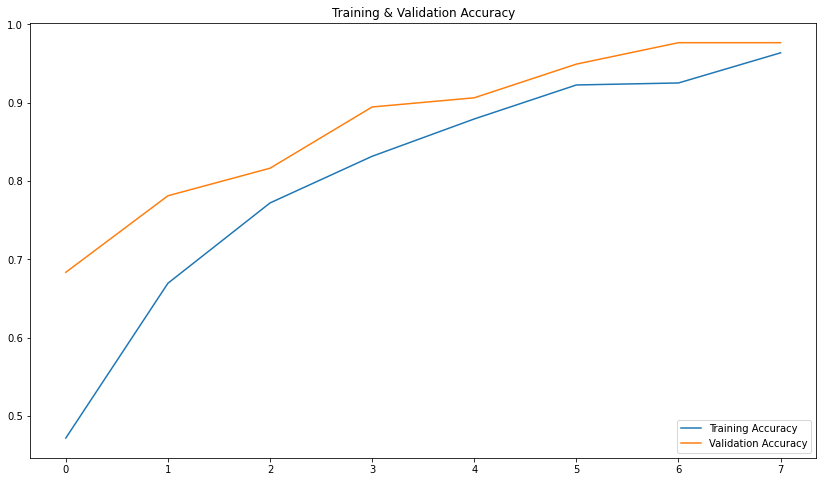

In [24]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(8), acc, label='Training Accuracy')
plt.plot(range(8), val_acc, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

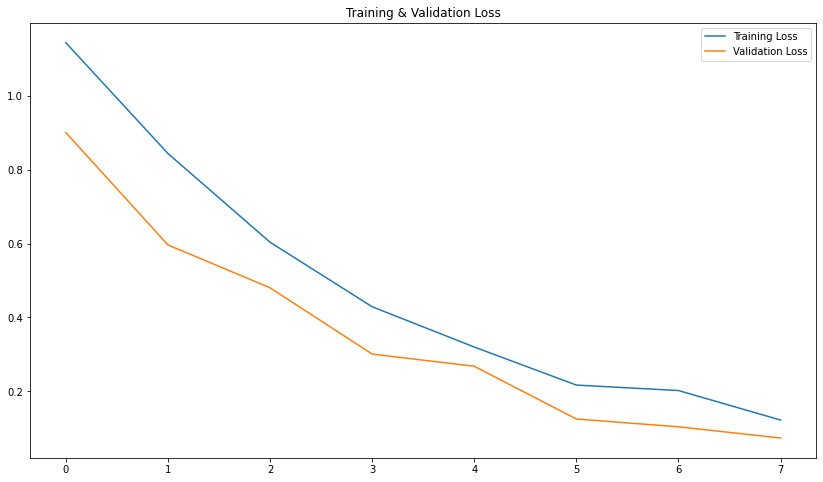

In [25]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(8), loss, label='Training Loss')
plt.plot(range(8), val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.title('Training & Validation Loss')

In [26]:
batch1 =test.take(1)


True : Blast
Predicted : Blast


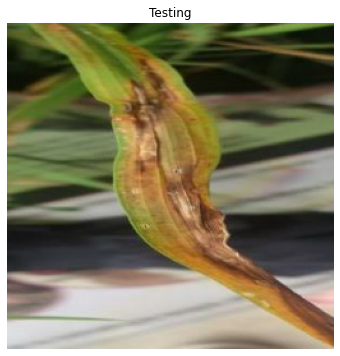

In [27]:
plt.figure(figsize=(6,6))
for img, clf in batch1:
    random_img = img[0].numpy().astype('uint8')
    typ = clf[0].numpy()
    plt.imshow(random_img)
    plt.axis('off')
    plt.title("Testing")
    prediction = model.predict(img)
    print("\nTrue :",disease[typ])
    print("Predicted :",disease[np.argmax(prediction[0])])

In [28]:
def pred(img):
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = tf.expand_dims(array,0)
    prediction = model.predict(array)
    clf = disease[np.argmax(prediction[0])]
    conf = round(100 * (np.max(prediction[0])), 2)
    return clf, conf

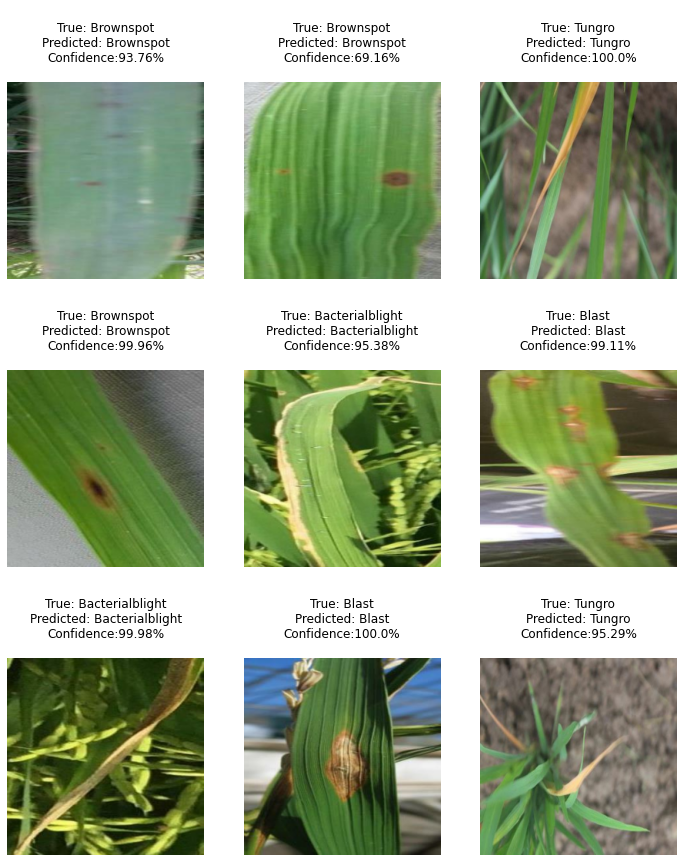

In [29]:
plt.figure(figsize=(12,15))
for img, lab in batch1:
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        prediction, confidence = pred(img[i].numpy())
        true = disease[lab[i]]
        plt.title(f"\nTrue: {true}\nPredicted: {prediction}\nConfidence:{confidence}%\n")
        plt.axis('off')

In [30]:
model.save("weight14callBacks.h5")

In [31]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

open('weight14callbacks.tflite','wb').write(tfmodel)

741292

In [32]:
!pip install tf-nightly

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\http\client.py", line 462, in read
    n = self.readinto(b)
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\http\client.py", line 506, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\Lenovo\an

  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\site-packages\pip\_internal\resolution\resolvelib\candidates.py", line 156, in __init__
    self.dist = self._prepare()
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\site-packages\pip\_internal\resolution\resolvelib\candidates.py", line 227, in _prepare
    dist = self._prepare_distribution()
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\site-packages\pip\_internal\resolution\resolvelib\candidates.py", line 305, in _prepare_distribution
    return self._factory.preparer.prepare_linked_requirement(
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\site-packages\pip\_internal\operations\prepare.py", line 508, in prepare_linked_requirement
    return self._prepare_linked_requirement(req, parallel_builds)
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\site-packages\pip\_internal\operations\prepare.py", line 550, in _prepare_linked_requirement
    local_file = unpack_url(
  File "C:\Users\Lenovo\anaconda3\envs\env_2\lib\site-packages\p

In [33]:
from keras.models import load_model
model_new = load_model("weight14callBacks.h5")

In [34]:
score1 = model_new.evaluate(test)

31/31 [==============================] - 2s 44ms/step - loss: 0.0921 - accuracy: 0.9660


In [36]:
import tensorflow as tf

model1 = tf.keras.models.load_model('weight14callBacks.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model = converter.convert()
open("weight14callBacks.tflite", "wb").write(tflite_model)

741712